# Quantum assisted Self-Organizing Feature Map

## Bag of words

In [1]:
import copy
import itertools
import json
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qiskit

from matplotlib.gridspec import GridSpec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import pairwise_distances
from qiskit_aer import AerSimulator

Abstracts

In [2]:
!cat ../assets/articles.json

{
    "arxiv:quant-ph": [
        [
            "Quantum computing and the brain: quantum nets, dessins d'enfants and neural networks",
            "In this paper, we will discuss a formal link between neural networks and quantum computing. For that purpose we will present a simple model for the description of the neural network by forming sub-graphs of the whole network with the same or a similar state. We will describe the interaction between these areas by closed loops, the feedback loops. The change of the graph is given by the deformations of the loops. This fact can be mathematically formalized by the fundamental group of the graph. Furthermore the neuron has two basic states |0⟩ (ground state) and |1⟩ (excited state). The whole state of an area of neurons is the linear combination of the two basic state with complex coefficients representing the signals (with 3 Parameters: amplitude, frequency and phase) along the neurons. Then it can be shown that the set of all signals forms a

In [3]:
with open("../assets/articles.json") as f:
    sample = json.load(f)

abstracts, ori_labels = ([item[1] for _, v in sample.items() for item in v], [0, 0, 0, 1, 1, 1, 2, 2, 2])

In [4]:
CUSTOM_STOP_WORDS = {"level"}
BAG_OF_WORD_SIZE = 9


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if (
                t.isalpha()
                and self.wnl.lemmatize(t) not in ENGLISH_STOP_WORDS | CUSTOM_STOP_WORDS
                and t not in ENGLISH_STOP_WORDS | CUSTOM_STOP_WORDS
            )
        ]


vectorizer = CountVectorizer(
    max_features=BAG_OF_WORD_SIZE,
    binary=True,
    tokenizer=LemmaTokenizer(),
    min_df=2,
    max_df=4,
)

/Users/kephircheek/venvs/science/qasofm-dev/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


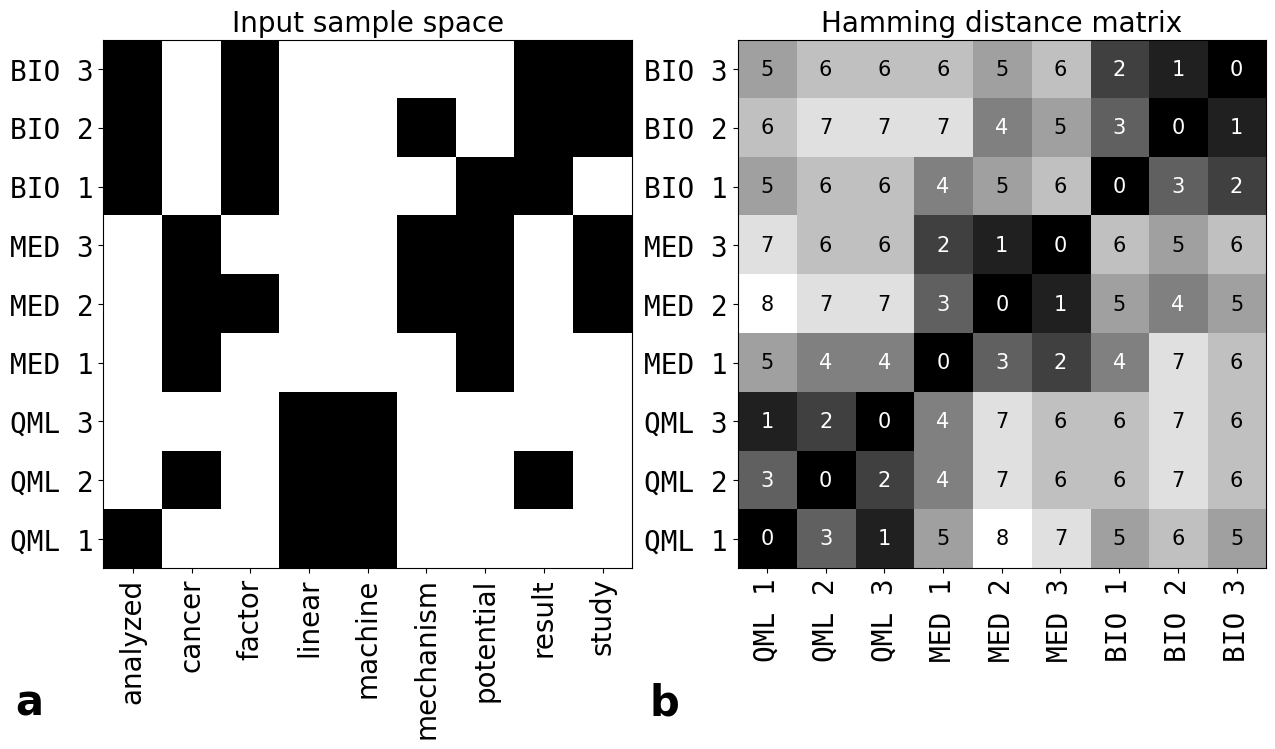

In [5]:
abstracts_vec = vectorizer.fit_transform(abstracts).toarray()
words = [item for item, _ in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax = axes[0]
im = ax.imshow(~abstracts_vec, cmap="gray", origin="lower")
ax.set_xticks(range(0, abstracts_vec.shape[1]))
ax.set_xticklabels(words, rotation=90, fontsize="20")
ax.set_yticks(range(0, abstracts_vec.shape[0]))
ax.set_title("Input sample space", fontsize="20")
ax.set_yticklabels(
    map(lambda x: " ".join(map(str, x)), zip(["QML"] * 3 + ["MED"] * 3 + ["BIO"] * 3, [1, 2, 3] * 3)),
    fontsize="20",
    family="monospace",
)
ax.text(-2, -3, "a", color="k", fontsize="30", fontweight="bold")


cd = pairwise_distances(abstracts_vec, metric="cityblock").astype(int)

ax = axes[1]
# im = ax.imshow(np.sin(np.pi/2/BAG_OF_WORD_SIZE * cd), cmap='gray')
im = ax.imshow(cd, cmap="gray", origin="lower")
ax.set_xticks(range(0, abstracts_vec.shape[1]))
ax.set_xticklabels(
    map(lambda x: " ".join(map(str, x)), zip(["QML"] * 3 + ["MED"] * 3 + ["BIO"] * 3, [1, 2, 3] * 3)),
    fontsize="20",
    family="monospace",
    rotation=90,
)
ax.set_yticks(range(0, abstracts_vec.shape[0]))
ax.set_yticklabels(
    map(lambda x: " ".join(map(str, x)), zip(["QML"] * 3 + ["MED"] * 3 + ["BIO"] * 3, [1, 2, 3] * 3)),
    fontsize="20",
    family="monospace",
)
ax.set_title("Hamming distance matrix", fontsize="20")

for i in range(cd.shape[0]):
    for j in range(cd.shape[1]):
        text = ax.text(
            j,
            i,
            cd[i, j],
            ha="center",
            va="center",
            color=("w" if cd[i, j] < BAG_OF_WORD_SIZE / 2 else "k"),
            fontsize="15",
        )

ax.text(-2, -3, "b", color="k", fontsize="30", fontweight="bold")

plt.savefig("./vectorized_sample.pdf", bbox_inches="tight")
plt.savefig("./vectorized_sample.eps", bbox_inches="tight")

## QASOFM 

In [6]:
from sklearn.metrics import hamming_loss

In [7]:
def cneighbor(sample, clusters):
    """find neigbour by classic enumeration
    Test:
        >>> cneighbor([0, 0, 0], [[0, 1, 0], [0, 1, 1]])
        0
    """
    return np.argmin([sum(np.logical_xor(sample, item)) for item in clusters])


def cdist(sample, clusters):
    """classic hamming distance for each cluster
    Test:
        >>> cdist([0, 0, 0], [[0, 1, 0], [0, 1, 1]])
        [1, 2]
    """
    return [sum(np.logical_xor(sample, item)) for item in clusters]


# def cos_cdist(sampl):


def shift(sample, cluster, rate=1):
    """
    >>> shift(np.array([0, 0, 1]), np.array([0, 1, 0]))
    array([0, 0, 0])

    >>> shift(np.array([1, 1, 1]), np.array([1, 0, 0]))
    array([1, 1, 0])
    """
    d = np.logical_xor(sample, cluster).astype("int64")
    cluster[np.argmax(d)] = int(not cluster[np.argmax(d)])
    return cluster


def n_state(state):
    """return number of state in full superposition

    Example:
        >>> n_state([0, 1, 1])
        3
        >>> n_state([1, 1, 1])
        7
    """
    return sum([(2**n) * v for n, v in zip(range(len(state) - 1, -1, -1), state)])


def compile_stack(states):
    """initialize state on qunatum cicuit"""

    stack = np.zeros(2 ** len(states[0]))
    for state in states:
        stack[n_state(state)] = 1

    return stack / np.sqrt(stack.sum())


import doctest

doctest.testmod()

TestResults(failed=0, attempted=6)

In [8]:
def qdist_cirtuit(sample, clusters):
    x = qiskit.QuantumRegister(len(sample), "sample")
    y = qiskit.QuantumRegister(len(clusters[0]), "cluster")
    a = qiskit.QuantumRegister(1, "ancila")

    cy = qiskit.ClassicalRegister(y.size, "clucter_c")
    ca = qiskit.ClassicalRegister(a.size, "ancila_c")

    circ = qiskit.QuantumCircuit(x, y, a, cy, ca)

    circ.initialize(compile_stack([sample]), x)
    circ.initialize(compile_stack(clusters), y)

    circ.h(a)
    circ.barrier()

    circ.cx(y, x)
    circ.barrier()

    circ.crz(np.pi / x.size, x, a)
    circ.barrier()

    circ.cx(y, x)
    circ.h(a)
    circ.barrier()

    circ.measure(y, cy)
    circ.measure(a, ca)

    return circ

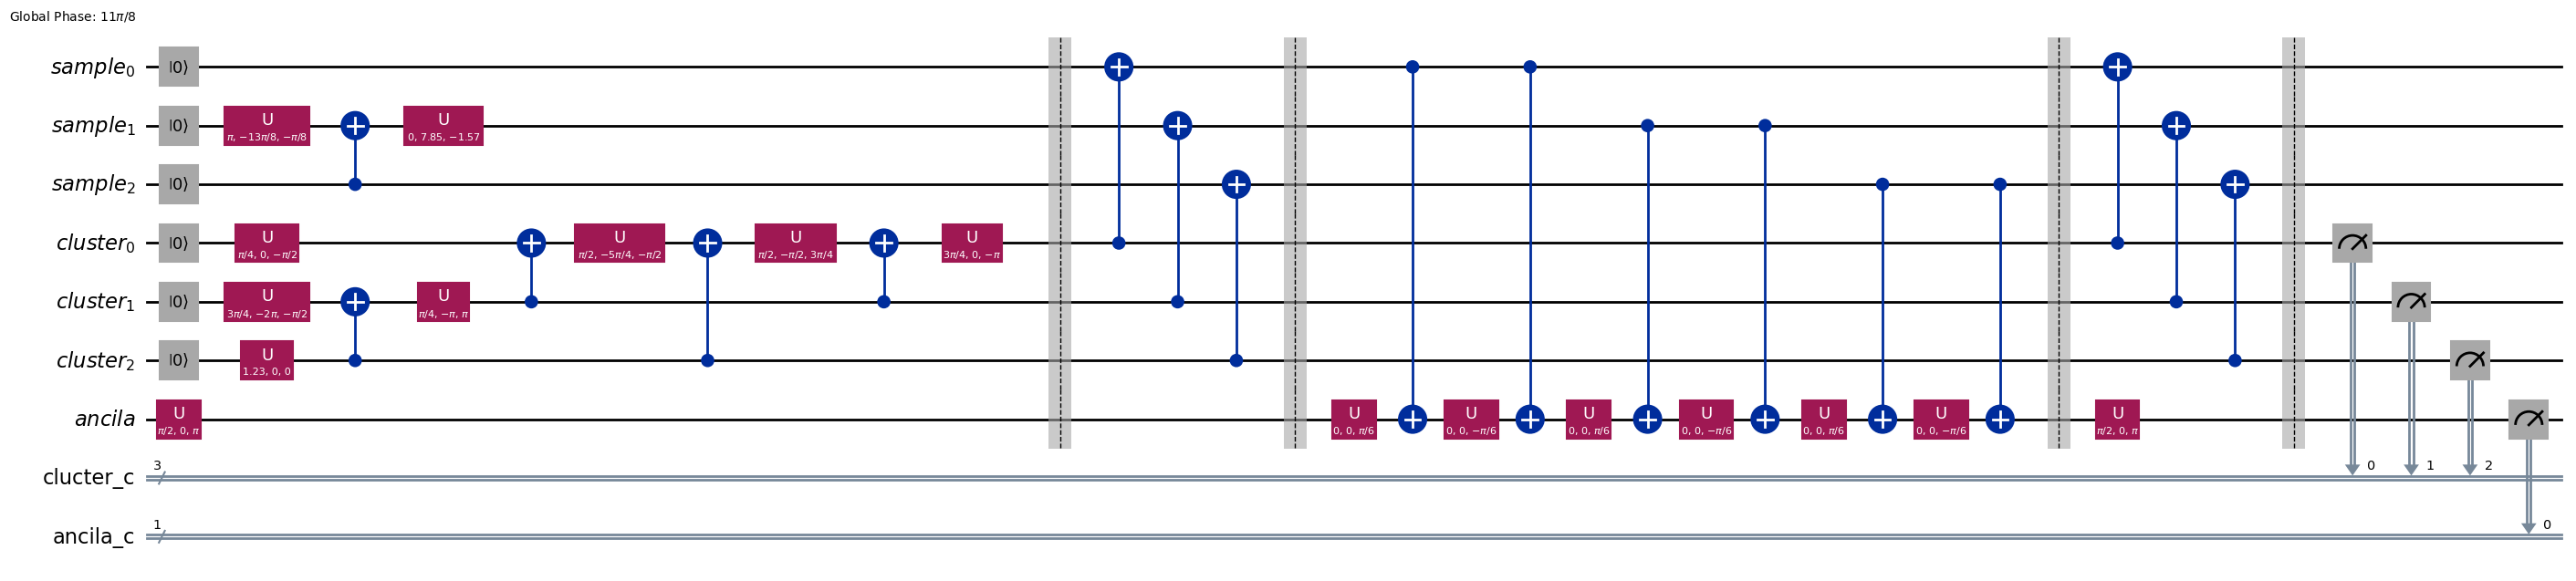

In [9]:
qdist_cirtuit([0, 1, 0], [[0, 0, 1], [0, 1, 0], [1, 0, 0]]).decompose(reps=6).draw(output="mpl", fold=-1)

In [10]:
def qdist(sample, clusters, shots, seed_simulator=None):
    """Quantum hamming distance for each cluster"""
    circ = qdist_cirtuit(sample, clusters)
    backend = AerSimulator()
    job = backend.run(circ, seed_simulator=seed_simulator, shots=shots)  # 26
    result = job.result()
    counts = result.get_counts()
    return [counts.get("1 " + "".join(map(str, cluster)), 0) for cluster in clusters]

In [11]:
def sofm(samples, clusters, n_epoch=10, distfun=cdist):
    clusters = copy.deepcopy(clusters)
    labels = np.zeros((n_epoch + 1, samples.shape[0]))
    for inx, sample in enumerate(samples):
        distances = cdist(sample, clusters)
        labels[0][inx] = np.argmin(distances)
    for e, _ in enumerate(range(n_epoch), 1):
        t0 = time.time()
        for inx, sample in enumerate(samples):
            distances = distfun(sample, clusters)
            labels[e][inx] = np.argmin(distances)
            clusters = [
                shift(sample, cluster) if dist <= np.sort(distances)[0] else cluster
                for cluster, dist in zip(clusters, distances)
            ]

        print("Epoch:", e, " | time:", round((time.time() - t0) / 60, 1), "min")
    return labels.astype(np.int32), clusters

In [12]:
%%time

epochs = 5
initial_clusters = [[1, 1, 0, 0, 1, 0, 0, 1, 1], [0, 1, 1, 0, 1, 0, 1, 1, 0], [1, 1, 0, 1, 1, 1, 1, 1, 0]]
shots = 64
seed_simulator = 10
dist_fun = lambda x, y: qdist(x, y, shots=shots, seed_simulator=seed_simulator)
# dist_fun = cdist
labels, clusters = sofm(abstracts_vec, initial_clusters, epochs, dist_fun)

Epoch: 1  | time: 0.3 min
Epoch: 2  | time: 0.3 min
Epoch: 3  | time: 0.3 min
Epoch: 4  | time: 0.3 min
Epoch: 5  | time: 0.3 min
CPU times: user 10min 43s, sys: 9.15 s, total: 10min 52s
Wall time: 1min 27s


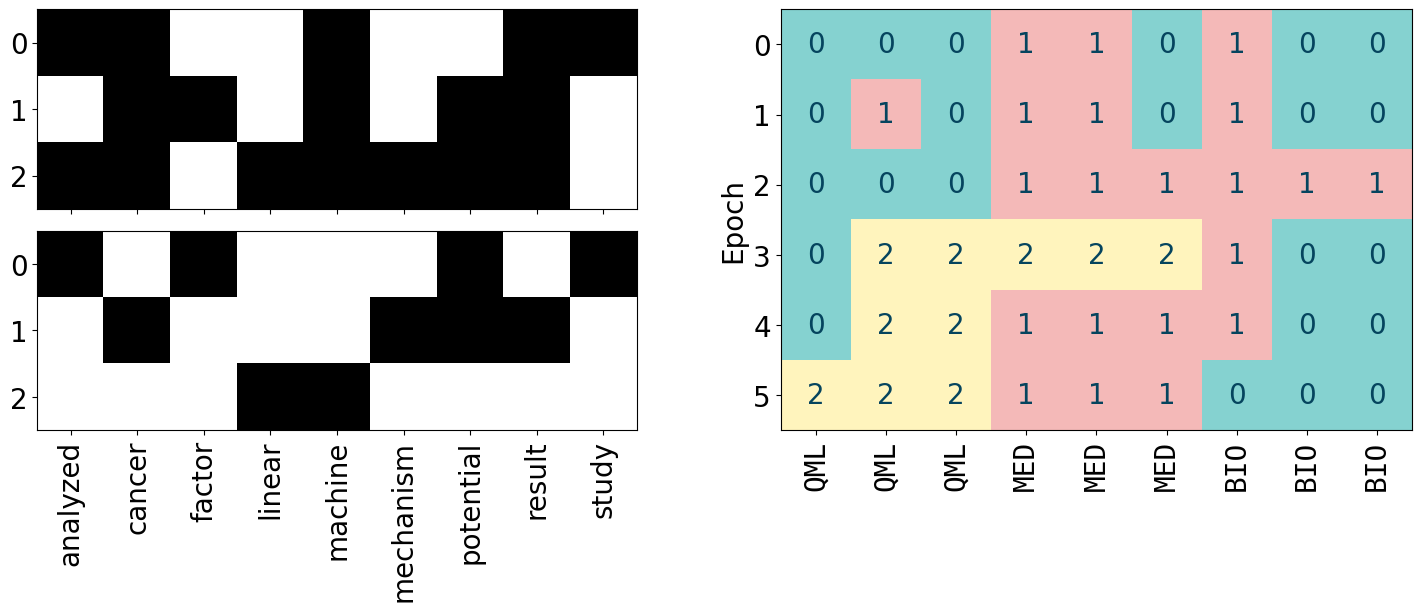

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = GridSpec(2, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.imshow(~np.array(initial_clusters), cmap="gray")
ax.set_xticks(range(0, abstracts_vec.shape[1]))
ax.set_xticklabels([], rotation=90, fontsize="20")
ax.set_yticks(range(3))
ax.set_yticklabels(range(3), fontsize="20")

ax = fig.add_subplot(gs[1, 0])
ax.imshow(~np.array(clusters), cmap="gray")
ax.set_xticks(range(0, abstracts_vec.shape[1]))
ax.set_xticklabels(words, rotation=90, fontsize="20")
ax.set_yticks(range(0, 3))
ax.set_yticklabels(range(3), fontsize="20")


ax = fig.add_subplot(gs[:, 1])
my_cmap = mpl.colors.ListedColormap(["#85D2D0", "#F4B9B8", "#FFF4BD"])
ax.imshow(labels, cmap=my_cmap)
ax.set_ylabel("Epoch", fontsize="20")
ax.set_yticks(range(epochs + 1))
ax.set_yticklabels(range(epochs + 1), fontsize="20")
ax.set_xticks(range(9))
ax.set_xticklabels(["QML"] * 3 + ["MED"] * 3 + ["BIO"] * 3, fontsize="20", family="monospace", rotation=90)

for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        text = ax.text(j, i, labels[i, j], ha="center", va="center", color="#05445E", fontsize="20")